In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D 

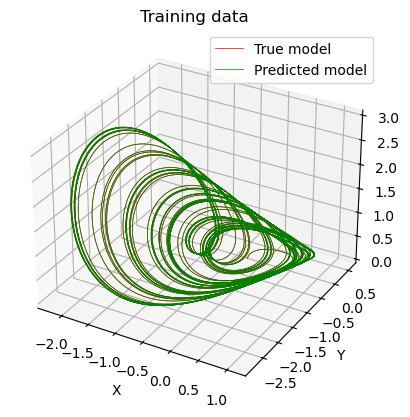

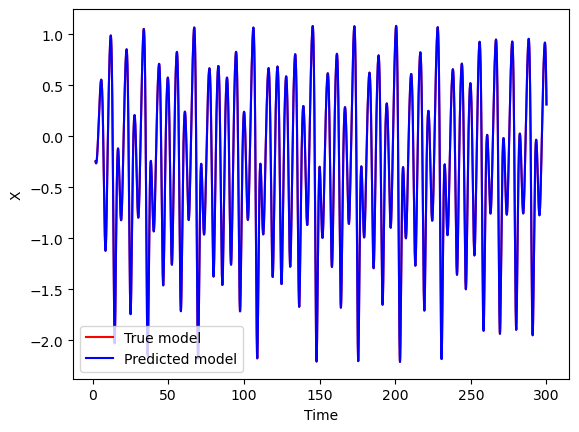

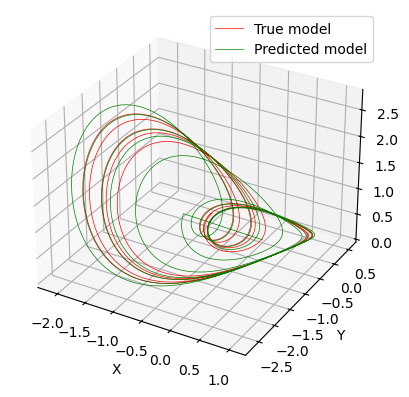

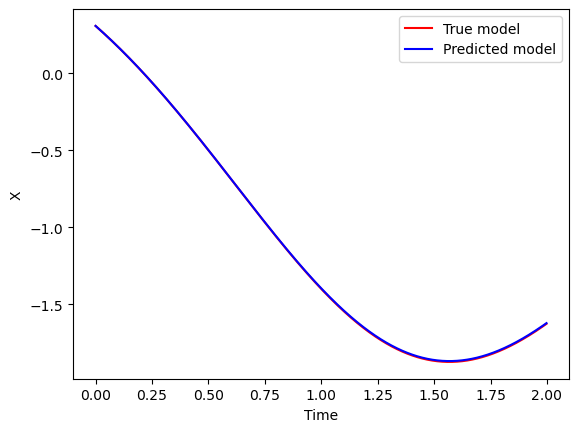

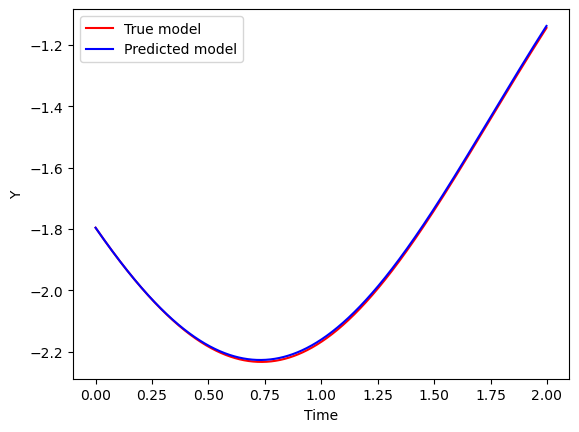

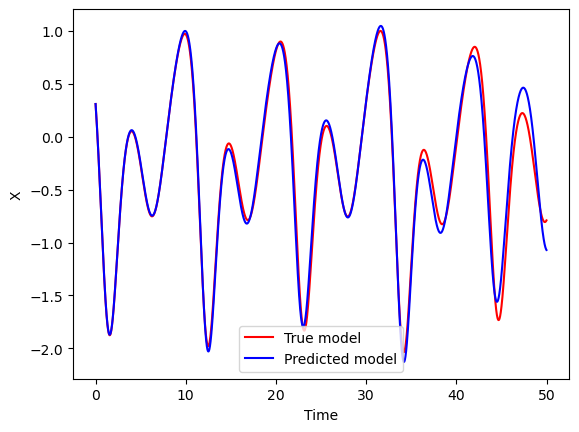

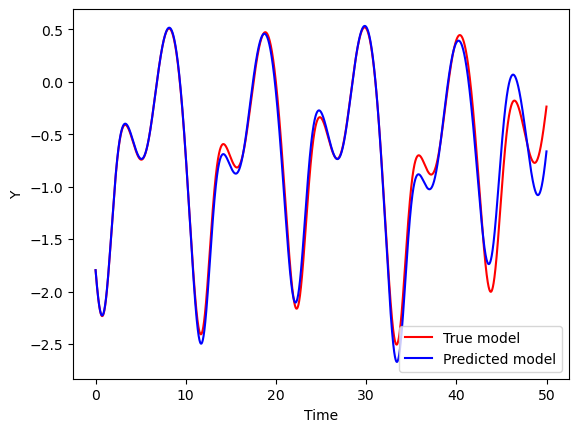

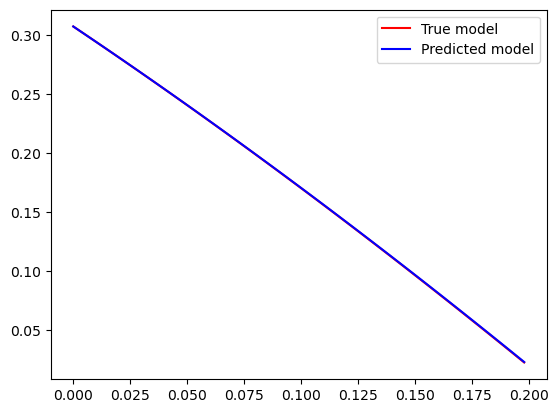

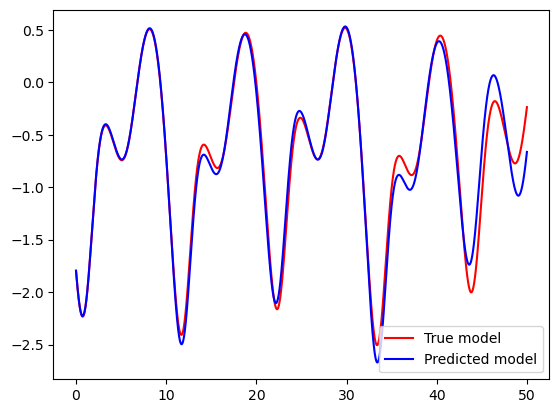

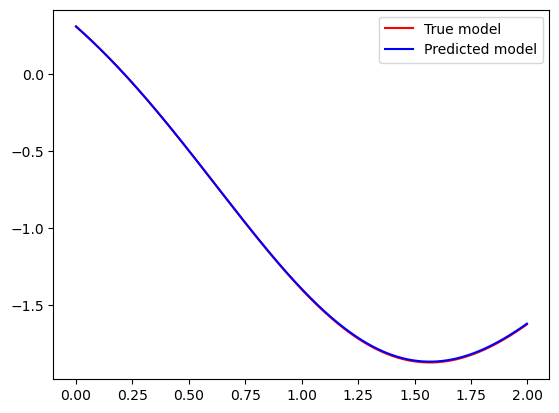

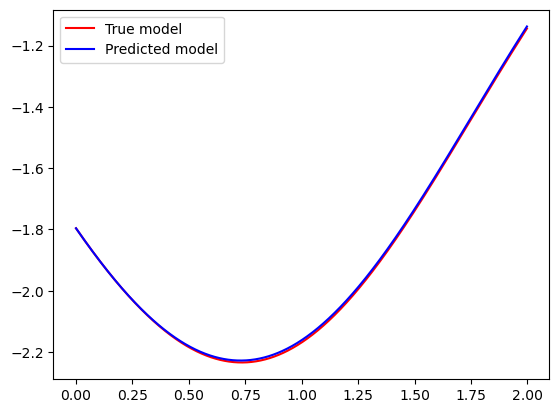

In [2]:
### Initializing parameters for training

## Sprott-Linz system parameters 
a = 0.420

## Reservoir parameters
n = 500                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 1e-4              # Lambda for ridge regression

## Simulation parameters
T = 300
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
# Win = 0.01 * (2.0 * np.random.rand(n, m) - 1) ######## Ask about scaling - he didn't have 0.01*
Win =  0.1*(2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Sprott-Linz system, time-series data of reservoir states R 
## and time-series data of system states f
x0 = 1.0 * np.random.rand() - 0.5
y0 = 1.0 * np.random.rand() - 0.5
z0 = 1.0 * np.random.rand() - 0.5
x, y, z = x0, y0, z0
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
#rpid0 = 0.5 - 1.0 * np.random.rand(n) ########## Ask about scaling - he has it between -1 to 1, we have it as -0.5 to 0.5
rpid0 = 2*(0.5 - 1.0 * np.random.rand(n))
rpid = rpid0

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = y + z 
    yp = -x + a * y 
    zp = x**2 - z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u

## Finding Wout matrix using ridge regression

f = f[:, 1000:]
R = R[:, 1000:]

Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

## Checking training data

tempout = Wout_pid.dot(R)
plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(f[0], f[1], f[2], 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(tempout[0], tempout[1], tempout[2], 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training data')
plt.show()

## Plot training data vs time
plt.figure()
plt.plot(trainingtimes[1001:], f[0], 'r', label = 'True model')
plt.plot(trainingtimes[1001:], tempout[0],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()

## Initializing testing parameters
Ttest = 50
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)


xxpure, yypure, zzpure = x, y, z
xxtrack, yytrack, zztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = yypure + zzpure
    yypurep = -xxpure + a * yypure
    zzpurep = xxpure**2 - zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   


    ## Forecasting

    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack])) + np.ones(n))
    xxtrack, yytrack, zztrack = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack

 



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xtrack, ytrack, ztrack, 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xtrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ytrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
plt.plot(testingtimes[:100], xtrack[:100],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], ypure, 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xtrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ytrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()


